### Validation for lake level derived by SWOT data.
#### 1. Comparison among the lake levels derived by SWOT pixc data, SWOT LakeSp data, and DAHITI data.
#### 2. Comparison between simple average and area-weighted average method in swot pixc data processing.

In [1]:
import pickle
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import netCDF4 as nc
import seaborn as sns
from datetime import datetime
import matplotlib.ticker as ticker 
from matplotlib import dates as mdates
from matplotlib.ticker import MultipleLocator
from utils.date_transform import date_to_decimal, decimal_to_date


In [2]:
## 设置全局字体和样式
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 设置为微软雅黑
plt.rcParams['font.weight'] = 'bold'  # 设置全局字体加粗
plt.rcParams['axes.labelweight'] = 'bold'  # 坐标轴标签加粗
plt.rcParams['axes.titleweight'] = 'bold'  # 标题加粗


### 1. swot pixc vs swot lakesp vs dahiti 

#### 1.1 DAHITI水位数据处理（转换基准为EGM2008）

In [3]:
path_DAHITI_data1= 'data/dahiti/Dan Chi.nc'  # Adjusted path for local testing
DAHITI_dianchi= nc.Dataset(path_DAHITI_data1)
time_date = DAHITI_dianchi.variables['datetime'][:]  
water_level_var = DAHITI_dianchi.variables['water_level'][:]
dates = [datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d') for dt in time_date] 


/var/folders/n0/3pzbdww50rgbs420szyd042c0000gn/T/ipykernel_4787/2986945101.py:4: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  water_level_var = DAHITI_dianchi.variables['water_level'][:]
/var/folders/n0/3pzbdww50rgbs420szyd042c0000gn/T/ipykernel_4787/2986945101.py:4: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  water_level_var = DAHITI_dianchi.variables['water_level'][:]


In [4]:
# DAHITI 月的平均水位数据 
df = pd.DataFrame({  
    'datetime': pd.to_datetime(time_date),  
    'water_level_DAHITI': water_level_var  
    })  

## 将日期设置为每月的第一天  
df['year_month'] = df['datetime'].dt.to_period('M') 
monthly_level_dianchi = df.groupby('year_month')['water_level_DAHITI'].mean().reset_index()

print(monthly_level_dianchi) 



    year_month  water_level_DAHITI
0      2016-05         1887.415039
1      2016-06         1887.439941
2      2016-07         1887.421997
3      2016-08         1887.483032
4      2016-09         1887.536011
..         ...                 ...
99     2024-09         1887.557983
100    2024-10         1887.668945
101    2024-11         1887.660034
102    2024-12         1887.693970
103    2025-01         1887.602051

[104 rows x 2 columns]


In [5]:
#基准由DAHITI的EIGEN-6C4转为wgs84,再转为EGM2008
monthly_level_dianchi['water_level_DAHITI'] = monthly_level_dianchi['water_level_DAHITI'] + (-32.2242)-(-32.1375)
print(monthly_level_dianchi)


    year_month  water_level_DAHITI
0      2016-05         1887.328247
1      2016-06         1887.353149
2      2016-07         1887.335205
3      2016-08         1887.396240
4      2016-09         1887.449219
..         ...                 ...
99     2024-09         1887.471191
100    2024-10         1887.582153
101    2024-11         1887.573242
102    2024-12         1887.607178
103    2025-01         1887.515259

[104 rows x 2 columns]


#### 1.2 基于SWOT Pixc数据的水位信息

In [6]:
path_pixc_wse = 'data/swot_l2/pixc/dianchi-lake/dianchi_heights_lake.pkl'  
with open(path_pixc_wse, 'rb') as file:  
    pixc_wse = pickle.load(file)      
    df = pd.DataFrame.from_dict(pixc_wse, orient='index').reset_index()  
    df.columns = ['decimal_date', 'SWOT_pixc_wse']  
    
    # 转换日期
    df['date'] = df['decimal_date'].apply(decimal_to_date)  
    df['year_month'] = pd.to_datetime(df['date']).dt.to_period('M') 
    pixc_wse_month = df.groupby('year_month')['SWOT_pixc_wse'].mean().reset_index()
    
    # 将Period转换为字符串格式
    pixc_wse_month['year_month'] = pixc_wse_month['year_month'].astype(str)  
    print("\n月度平均水位结果:")  
    print(pixc_wse_month)  



月度平均水位结果:
   year_month  SWOT_pixc_wse
0     2023-08    1887.866699
1     2023-09    1887.759888
2     2023-10    1887.797241
3     2023-11    1887.750366
4     2023-12    1887.763916
5     2024-01    1887.703491
6     2024-02    1887.785645
7     2024-03    1887.715210
8     2024-04    1887.640381
9     2024-05    1887.488281
10    2024-06    1887.596680
11    2024-07    1887.601440
12    2024-08    1887.715576
13    2024-09    1887.783691
14    2024-10    1887.892456
15    2024-11    1887.767578
16    2024-12    1887.793823


#### 1.3 基于LakeSP数据的SWOT水位信息

In [7]:
path_LakeSP_wse = 'data/swot_l2/lakesp/dianchi-lake/dianchi_wse_lakesp.pkl'

with open(path_LakeSP_wse, 'rb') as file:  
    LakeSP_wse = pickle.load(file)  
    
    df = pd.DataFrame.from_dict(LakeSP_wse, orient='index').reset_index()  
    df.columns = ['decimal_date', 'SWOT_LakeSP_wse']  
    
    #转换日期
    df['date'] = df['decimal_date'].apply(decimal_to_date)  
    df['year_month'] = pd.to_datetime(df['date']) .dt.to_period('M')
    
    # 计算月平均值      
    LakeSP_wse_month = df.groupby('year_month')['SWOT_LakeSP_wse'].mean().reset_index()  
    LakeSP_wse_month['year_month'] = LakeSP_wse_month['year_month'].astype(str)  
    
    print("\n月度平均水位结果:")  
    print(LakeSP_wse_month)  
    



月度平均水位结果:
   year_month  SWOT_LakeSP_wse
0     2023-08      1887.907000
1     2023-09      1887.924500
2     2023-10      1887.983333
3     2023-11      1888.191500
4     2023-12      1887.847500
5     2024-01      1888.042000
6     2024-02      1887.939500
7     2024-03      1887.800000
8     2024-04      1887.781000
9     2024-05      1887.542000
10    2024-07      1887.727000
11    2024-08      1887.872000
12    2024-09      1887.853000


#### 1.4 数据合并及对比分析   
合并数据--均方根计算--可视化

In [18]:
## 合并三个水位产品
df1 = pd.DataFrame(LakeSP_wse_month).assign(year_month=lambda x: x['year_month'].astype(str))
df2 = pd.DataFrame(pixc_wse_month).assign(year_month=lambda x: x['year_month'].astype(str))
df3 = pd.DataFrame(monthly_level_dianchi).assign(year_month=lambda x: x['year_month'].astype(str))
# 一次性合并三个 DataFrame（按 'year_month' 列）
pixc_lakesp_dahiti_df = df1.merge(df2, on='year_month', how='outer').merge(df3, on='year_month', how='outer')
# 删除包含 NaN 的行
pixc_lakesp_dahiti_df = pixc_lakesp_dahiti_df.dropna(thresh=3)
print(pixc_lakesp_dahiti_df)


    year_month  SWOT_LakeSP_wse  SWOT_pixc_wse  water_level_DAHITI
86     2023-08      1887.907000    1887.866699         1887.499268
87     2023-09      1887.924500    1887.759888         1887.431152
88     2023-10      1887.983333    1887.797241         1887.530151
89     2023-11      1888.191500    1887.750366         1887.597168
90     2023-12      1887.847500    1887.763916         1887.448242
91     2024-01      1888.042000    1887.703491         1887.426147
92     2024-02      1887.939500    1887.785645         1887.460205
93     2024-03      1887.800000    1887.715210         1887.459229
94     2024-04      1887.781000    1887.640381         1887.319214
95     2024-05      1887.542000    1887.488281         1887.174194
96     2024-06              NaN    1887.596680         1887.294189
97     2024-07      1887.727000    1887.601440         1887.264160
98     2024-08      1887.872000    1887.715576         1887.464233
99     2024-09      1887.853000    1887.783691         1887.47

In [10]:
#计算均方根误差和相关性
diff1 = pixc_lakesp_dahiti_df['SWOT_LakeSP_wse'] - pixc_lakesp_dahiti_df['water_level_DAHITI']
diff2 = pixc_lakesp_dahiti_df['SWOT_pixc_wse'] - pixc_lakesp_dahiti_df['water_level_DAHITI']

## 计算差值的均值(系统偏差)
mean_diff1 = diff1.mean()
mean_diff2 = diff2.mean()

# 将均值加到wse_month列（以DAHITI为参考, 消除系统偏差）
pixc_lakesp_dahiti_df['SWOT_LakeSP_wse_cor'] = pixc_lakesp_dahiti_df['SWOT_LakeSP_wse'] - mean_diff1
pixc_lakesp_dahiti_df['SWOT_pixc_wse_cor'] = pixc_lakesp_dahiti_df['SWOT_pixc_wse'] - mean_diff2


# 计算均方根误差（RMSE）  
rmse_SWOT_pixc_wse = np.sqrt(((pixc_lakesp_dahiti_df['SWOT_pixc_wse_cor'] - \
                                pixc_lakesp_dahiti_df['water_level_DAHITI']) ** 2).mean())  
rmse_SWOT_LakeSP_wse = np.sqrt(((pixc_lakesp_dahiti_df['SWOT_LakeSP_wse_cor'] - \
                                pixc_lakesp_dahiti_df['water_level_DAHITI']) ** 2).mean())  

# 计算相关性  
corr_SWOT_pixc_wse = pixc_lakesp_dahiti_df['SWOT_pixc_wse'].corr(pixc_lakesp_dahiti_df['water_level_DAHITI'])  
corr_SWOT_LakeSP_wse = pixc_lakesp_dahiti_df['SWOT_LakeSP_wse'].corr(pixc_lakesp_dahiti_df['water_level_DAHITI'])  

print(f"SWOT_pixc_wse与DAHITI_wse的均方根误差: {rmse_SWOT_pixc_wse:.4f}")  
print(f"SWOT_pixc_wse与DAHITI_wse的相关性: {corr_SWOT_pixc_wse:.4f}")  
print(f"SWOT_LakeSP_wse与DAHITI_wse的均方根误差: {rmse_SWOT_LakeSP_wse:.4f}")  
print(f"SWOT_LakeSP_wse与DAHITI_wse的相关性: {corr_SWOT_LakeSP_wse:.4f}") 


SWOT_pixc_wse与DAHITI_wse的均方根误差: 0.0523
SWOT_pixc_wse与DAHITI_wse的相关性: 0.8762
SWOT_LakeSP_wse与DAHITI_wse的均方根误差: 0.0789
SWOT_LakeSP_wse与DAHITI_wse的相关性: 0.8649


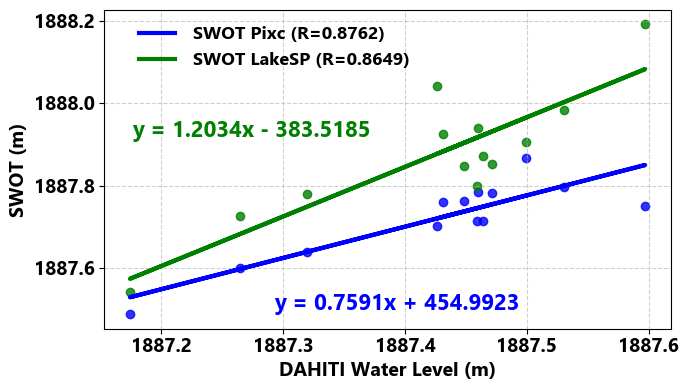

In [10]:


x, y_pixc, y_lakesp = pixc_lakesp_dahiti_df['water_level_DAHITI'].values, \
                      pixc_lakesp_dahiti_df['SWOT_pixc_wse'].values, \
                      pixc_lakesp_dahiti_df['SWOT_LakeSP_wse'].values
slope_pixc, intercept_pixc = np.polyfit(x, y_pixc, 1)
slope_LakeSP, intercept_LakeSP = np.polyfit(x, y_lakesp, 1)

plt.figure(figsize=(7, 4))

# 绘制散点图和回归线 - SWOT_pixc
plt.scatter(x, y_pixc, color='blue', alpha=0.8)  # 散点图
plt.plot(x, slope_pixc * x + intercept_pixc, 
         color='blue', linewidth=3, 
         label=f'SWOT Pixc (R={corr_SWOT_pixc_wse:.4f})')  # 回归线
# ## using seaborn for confidence interval ploting
# sns.regplot(x='water_level_DAHITI', y='SWOT_pixc_wse', 
#             data=pixc_lakesp_dahiti_df,  scatter_kws={'color': 'blue', 'alpha': 0.8}, 
#             line_kws={'color': 'blue','linewidth': 3, 'label': f'SWOT Pixc (R={corr_SWOT_pixc_wse:.4f})'})

# 计算线性回归参数
# 绘制散点图和回归线 - SWOT_LakeSP
plt.scatter(x, y_lakesp, color='green', alpha=0.8)  # 散点图
plt.plot(x, slope_LakeSP * x + intercept_LakeSP, 
         color='green', linewidth=3, 
         label=f'SWOT LakeSP (R={corr_SWOT_LakeSP_wse:.4f})')  # 回归线
## using seaborn for confidence interval ploting
# sns.regplot(x='water_level_DAHITI', y='SWOT_LakeSP_wse', 
#             data=pixc_lakesp_dahiti_df,  scatter_kws={'color': 'green', 'alpha': 0.8}, 
#             line_kws={'color': 'green','linewidth': 3, 'label': f'SWOT LakeSP (R={corr_SWOT_LakeSP_wse:.4f})'})

# # 设置坐标轴格式
plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))  # 显示一位小数
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))

equation_swot_LakeSP = f'y = {slope_LakeSP:.4f}x + {intercept_LakeSP:.4f}' \
                                        if intercept_LakeSP >= 0 else f'y = {slope_LakeSP:.4f}x - {-intercept_LakeSP:.4f}'
equation_swot_Pixc = f'y = {slope_pixc:.4f}x + {intercept_pixc:.4f}' \
                                        if intercept_pixc >= 0 else f'y = {slope_pixc:.4f}x - {-intercept_pixc:.4f}'

plt.text(0.05, 0.60, equation_swot_LakeSP, transform=plt.gca().transAxes, 
         fontsize=16, color='green', ha='left', bbox=dict(facecolor='none', alpha=0.8, edgecolor='none'))
plt.text(0.3, 0.06, equation_swot_Pixc, transform=plt.gca().transAxes, 
         fontsize=16, color='blue', ha='left', bbox=dict(facecolor='none', alpha=0.8, edgecolor='none'))

plt.legend(fontsize=13, frameon=False,
           loc='upper center', bbox_to_anchor=(0.3, 1.0),
           handletextpad=1, markerscale=1.5, labelspacing=0.5)

plt.xlabel('DAHITI Water Level (m)', fontsize=14)
plt.ylabel('SWOT (m)', fontsize=14)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().yaxis.set_major_locator(MultipleLocator(0.2))  # 主刻度间隔0.2
plt.tight_layout()


[Timestamp('2023-09-01 00:00:00'), Timestamp('2024-01-01 00:00:00'), Timestamp('2024-05-01 00:00:00'), Timestamp('2024-09-01 00:00:00')]


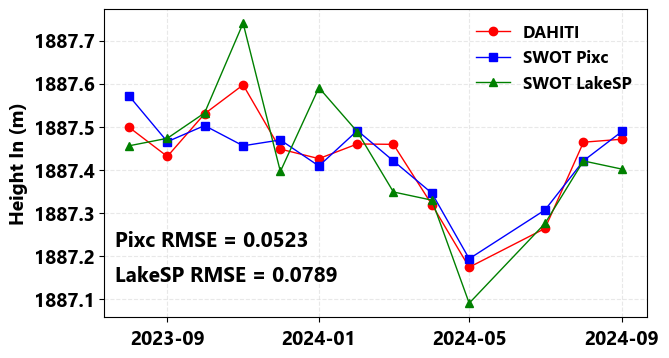

In [11]:
pixc_lakesp_dahiti_df = pd.DataFrame(pixc_lakesp_dahiti_df)
pixc_lakesp_dahiti_df['year_month'] = pd.to_datetime(pixc_lakesp_dahiti_df['year_month']) 


fig, ax = plt.subplots(figsize=(7, 4))  
ax.plot(pixc_lakesp_dahiti_df['year_month'], pixc_lakesp_dahiti_df['water_level_DAHITI'], 
         label='DAHITI', color='red', marker='o', markersize=6, 
         linewidth=1, linestyle='-')
ax.plot(pixc_lakesp_dahiti_df['year_month'], pixc_lakesp_dahiti_df['SWOT_pixc_wse_cor'], 
         label='SWOT Pixc', color='blue', marker='s', markersize=6, 
         linewidth=1, linestyle='-')
ax.plot(pixc_lakesp_dahiti_df['year_month'], pixc_lakesp_dahiti_df['SWOT_LakeSP_wse_cor'], 
         label='SWOT LakeSP', color='green', marker='^', markersize=6, 
         linewidth=1, linestyle='-')

ax.set_ylabel('Height In (m)', fontsize=14)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.1f}'))
ax.yaxis.set_major_locator(MultipleLocator(0.1))  # 每0.1单位一个主刻度
ax.grid(True, linestyle='--', alpha=0.5, color='lightgray')

# 添加RMSE标注
ax.text(0.02, 0.1, 
         f'Pixc RMSE = {rmse_SWOT_pixc_wse:.4f}\n\nLakeSP RMSE = {rmse_SWOT_LakeSP_wse:.4f}',
         fontsize=15, verticalalignment='bottom', 
         horizontalalignment='left', transform=ax.transAxes,
         linespacing=0.8)

ax.legend(loc='upper right', frameon=False, fontsize=12)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

# 固定刻度位置和标签
specific_months = ['2023-09', '2024-01', '2024-05', '2024-09']
specific_dates = [pd.to_datetime(month + '-01') for month in specific_months]
print(specific_dates)
ax.set_xticks(specific_dates)
ax.set_xticklabels(specific_months)

plt.xticks(rotation=0, ha='right', fontsize=14)
for label in ax.get_xticklabels():
    label.set_horizontalalignment('center')
    label.set_position((0, -0.01))

ax.tick_params(axis='y', labelsize=14)
pixc_lakesp_dahiti_df['year_month'] = pixc_lakesp_dahiti_df['year_month'].dt.to_period('M').astype(str)  # 将 year_month 列转换为 Period 类型
# merged_df


### 2. 像素云面积加权平均 vs 普通平均   
备注：基于pixc数据水位提取方法分析

#### 2.1 普通平均方法（非加权）所得结果

In [12]:
# 加载SWOT没有面积加权的数据 
path_unweight = 'data/swot_l2/pixc/dianchi-lake/dianchi_heights_lake_mean_sim.pkl'  
with open(path_unweight, 'rb') as file:  
    unweight_data = pickle.load(file)  
    df = pd.DataFrame.from_dict(unweight_data, orient='index').reset_index()  
    df.columns = ['decimal_date', 'pixc_wse_unweighted']  
    # 转换日期 
    df['date'] = df['decimal_date'].apply(decimal_to_date)  
    df['year_month'] = pd.to_datetime(df['date']).dt.to_period('M')      
    # 计算月度平均值  
    pixc_unweight_df = df.groupby('year_month')['pixc_wse_unweighted'].mean().reset_index()      
    # 转换 Period 为字符串格式  
    pixc_unweight_df['year_month'] = pixc_unweight_df['year_month'].astype(str)  
    print(pixc_unweight_df)  


   year_month  pixc_wse_unweighted
0     2023-08          1887.873634
1     2023-09          1887.768024
2     2023-10          1887.803068
3     2023-11          1887.754579
4     2023-12          1887.768764
5     2024-01          1887.698992
6     2024-02          1887.792806
7     2024-03          1887.719564
8     2024-04          1887.645272
9     2024-05          1887.492106
10    2024-06          1887.601671
11    2024-07          1887.610292
12    2024-08          1887.718455
13    2024-09          1887.787222
14    2024-10          1887.890172
15    2024-11          1887.772892
16    2024-12          1887.797945


#### 2.2 数据合并及处理

In [13]:
pixc_weighted_df = pixc_lakesp_dahiti_df[['year_month', 'SWOT_pixc_wse', 'SWOT_pixc_wse_cor', 'water_level_DAHITI']]
pixc_weighted_df = pixc_weighted_df.rename(columns={'SWOT_pixc_wse': 'pixc_wse_weighted', 
                                                'SWOT_pixc_wse_cor': 'pixc_wse_weighted_cor'})
# 按时间合并两个 DataFrame  
pixc_weighted_unweighted_df = pd.merge(pixc_unweight_df, pixc_weighted_df, left_on='year_month', right_on='year_month', how='outer')  
## 删除包含 NaN 的行
pixc_weighted_unweighted_df = pixc_weighted_unweighted_df.dropna()
# 非加权方法系统偏差改正（以dahiti为参考）
diff = pixc_weighted_unweighted_df['pixc_wse_unweighted'] - pixc_weighted_unweighted_df['water_level_DAHITI']
# 将均值加到elevation_month列（消除系统偏差）
pixc_weighted_unweighted_df['pixc_wse_unweighted_cor']= pixc_weighted_unweighted_df['pixc_wse_unweighted'] - diff.mean()
pixc_weighted_unweighted_df


,year_month,pixc_wse_unweighted,pixc_wse_weighted,pixc_wse_weighted_cor,water_level_DAHITI,pixc_wse_unweighted_cor
0,2023-08,1887.873634,1887.866699,1887.572266,1887.499268,1887.574540
1,2023-09,1887.768024,1887.759888,1887.465454,1887.431152,1887.468930
2,2023-10,1887.803068,1887.797241,1887.502808,1887.530151,1887.503974
3,2023-11,1887.754579,1887.750366,1887.455933,1887.597168,1887.455485
4,2023-12,1887.768764,1887.763916,1887.469482,1887.448242,1887.469670
5,2024-01,1887.698992,1887.703491,1887.409058,1887.426147,1887.399898
6,2024-02,1887.792806,1887.785645,1887.491211,1887.460205,1887.493712
7,2024-03,1887.719564,1887.715210,1887.420776,1887.459229,1887.420470
8,2024-04,1887.645272,1887.640381,1887.345947,1887.319214,1887.346178
9,2024-05,1887.492106,1887.488281,1887.193848,1887.174194,1887.193012


### 面积加权与非面积加权方法所得结果对比分析   
计算均方根误差、相关系数计算，以及结果可视化分析


In [14]:
# 计算均方根误差（RMSE）  
rmse_SWOT_weighted = np.sqrt(((pixc_weighted_unweighted_df['pixc_wse_weighted_cor'] - 
                               pixc_weighted_unweighted_df['water_level_DAHITI']) ** 2).mean())  
rmse_SWOT_unweight = np.sqrt(((pixc_weighted_unweighted_df['pixc_wse_unweighted_cor'] - 
                               pixc_weighted_unweighted_df['water_level_DAHITI']) ** 2).mean())  

# 计算相关性  
corr_SWOT_weighted = pixc_weighted_unweighted_df['pixc_wse_weighted'].\
                                    corr(pixc_weighted_unweighted_df['water_level_DAHITI'])  
corr_SWOT_unweighted = pixc_weighted_unweighted_df['pixc_wse_unweighted'].\
                                    corr(pixc_weighted_unweighted_df['water_level_DAHITI'])  

print(f"SWOT_weighted与DAHITI水位的均方根误差: {rmse_SWOT_weighted:.4f}")  
print(f"SWOT_weighted与DAHITI水位的相关性: {corr_SWOT_weighted:.4f}")  
print(f"SWOT_unweight与DAHITI水位的均方根误差: {rmse_SWOT_unweight:.4f}")  
print(f"SWOT_unweight与DAHITI水位的相关性: {corr_SWOT_unweighted:.4f}") 


SWOT_weighted与DAHITI水位的均方根误差: 0.0523
SWOT_weighted与DAHITI水位的相关性: 0.8762
SWOT_unweight与DAHITI水位的均方根误差: 0.0535
SWOT_unweight与DAHITI水位的相关性: 0.8697


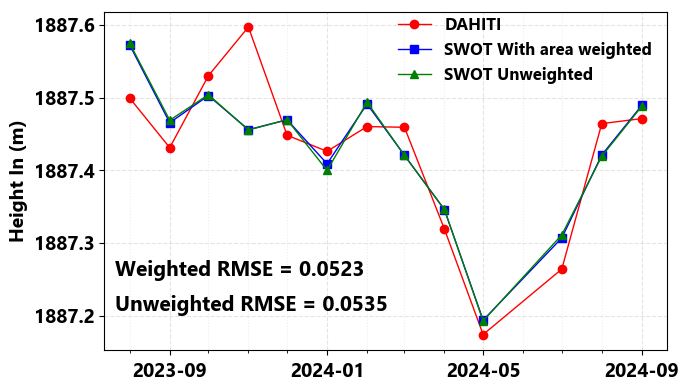

In [ ]:
pixc_weighted_unweighted_df = pd.DataFrame(pixc_weighted_unweighted_df)
# 将 year_month 转换为 datetime 类型
pixc_weighted_unweighted_df['year_month'] = pd.to_datetime(pixc_weighted_unweighted_df['year_month'])

fig, ax = plt.subplots(figsize=(7, 4))  
ax.plot(pixc_weighted_unweighted_df['year_month'], pixc_weighted_unweighted_df['water_level_DAHITI'], 
         label='DAHITI', color='red', marker='o', markersize=6, 
         linewidth=1.0, linestyle='-')
ax.plot(pixc_weighted_unweighted_df['year_month'], pixc_weighted_unweighted_df['pixc_wse_weighted_cor'], 
         label='SWOT With area weighted', color='blue', marker='s', markersize=6, 
         linewidth=1.0, linestyle='-')
ax.plot(pixc_weighted_unweighted_df['year_month'], pixc_weighted_unweighted_df['pixc_wse_unweighted_cor'], 
         label='SWOT Unweighted', color='green', marker='^', markersize=6, 
         linewidth=1.0, linestyle='-')

ax.set_ylabel('Height In (m)', fontsize=14)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.1f}'))
ax.grid(True, linestyle='--', alpha=0.6, color='lightgray')
ax.xaxis.set_minor_locator(mdates.MonthLocator())  # 次要刻度
ax.grid(which='minor', linestyle=':', alpha=0.4, color='lightgray')

# 添加RMSE标注
ax.text(0.02, 0.1, 
         f'Weighted RMSE = {rmse_SWOT_weighted:.4f}\n\nUnweighted RMSE = {rmse_SWOT_unweight:.4f}',
         fontsize=15, verticalalignment='bottom', 
         horizontalalignment='left', transform=ax.transAxes,
         linespacing=0.8)

ax.legend(loc='upper right', 
           frameon=False, 
           fontsize=12,
           bbox_to_anchor=(1.0, 1.03))

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

# 固定刻度位置和标签
specific_months = ['2023-09', '2024-01', '2024-05', '2024-09']
specific_dates = [pd.to_datetime(month + '-01') for month in specific_months]
ax.set_xticks(specific_dates)
ax.set_xticklabels(specific_months)

plt.xticks(rotation=0, ha='right', fontsize=14)
for label in ax.get_xticklabels():
    label.set_horizontalalignment('center')
    label.set_position((0, -0.01))

ax.tick_params(axis='y', labelsize=14)
plt.tight_layout()


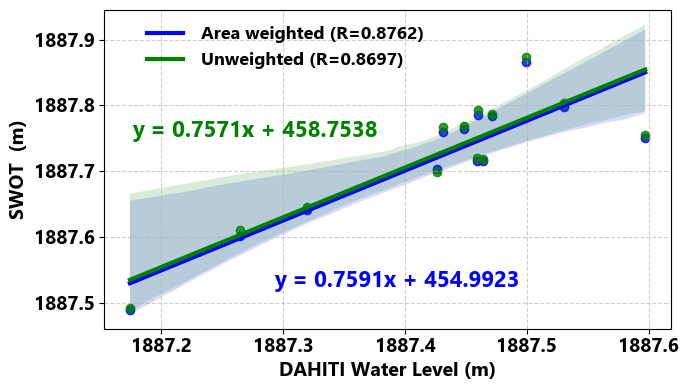

In [ ]:
# 计算线性回归参数
slope_swot_unweight, intercept_swot_unweight = np.polyfit(pixc_weighted_unweighted_df['water_level_DAHITI'], 
                                                          pixc_weighted_unweighted_df['pixc_wse_unweighted'], 1)
slope_swot_Pixc, intercept_swot_Pixc = np.polyfit(pixc_weighted_unweighted_df['water_level_DAHITI'], 
                                                  pixc_weighted_unweighted_df['pixc_wse_weighted'], 1)

plt.figure(figsize=(7, 4))

x = pixc_weighted_unweighted_df['water_level_DAHITI']
y_pixc = pixc_weighted_unweighted_df['pixc_wse_weighted']
y_unweight = pixc_weighted_unweighted_df['pixc_wse_unweighted']

## 绘制散点图和回归线 - SMOT_Pixc
plt.scatter(x, y_pixc, color='blue', alpha=0.8)  # 散点
plt.plot(x, slope_swot_Pixc * x + intercept_swot_Pixc, 
         color='blue', linewidth=3, 
         label=f'Area weighted (R={corr_SWOT_weighted:.4f})')  # 回归线
# sns.regplot(x='water_level_DAHITI', y='pixc_wse_weighted', data=pixc_weighted_unweighted_df,              
#             scatter_kws={'color': 'blue', 'alpha': 0.8}, 
#             line_kws={'color': 'blue','linewidth': 3, 'label': f'Area weighted (R={corr_SWOT_weighted:.4f})'})

## 绘制散点图和回归线 - SMOT_unweight
plt.scatter(x, y_unweight, color='green', alpha=0.8)  # 散点
plt.plot(x, slope_swot_unweight * x + intercept_swot_unweight, 
         color='green', linewidth=3, 
         label=f'Unweighted (R={corr_SWOT_unweighted:.4f})')  # 回归线
# sns.regplot(x='water_level_DAHITI', y='pixc_wse_unweighted', data=pixc_weighted_unweighted_df,  
#             scatter_kws={'color': 'green', 'alpha': 0.8}, 
#             line_kws={'color': 'green','linewidth': 3, 'label': f'Unweighted (R={corr_SWOT_unweighted:.4f})'})


plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))  # 显示一位小数
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
equation_swot_unweight = f'y = {slope_swot_unweight:.4f}x + {intercept_swot_unweight:.4f}' if intercept_swot_unweight >= 0 else f'y = {slope_swot_unweight:.4f}x - {-intercept_swot_unweight:.4f}'
equation_swot_Pixc = f'y = {slope_swot_Pixc:.4f}x + {intercept_swot_Pixc:.4f}' if intercept_swot_Pixc >= 0 else f'y = {slope_swot_Pixc:.4f}x - {-intercept_swot_Pixc:.4f}'

plt.text(0.05, 0.60, equation_swot_unweight, transform=plt.gca().transAxes, 
         fontsize=16, color='green', ha='left', bbox=dict(facecolor='none', alpha=0.8, edgecolor='none'))
plt.text(0.3, 0.13, equation_swot_Pixc, transform=plt.gca().transAxes, 
         fontsize=16, color='blue', ha='left', bbox=dict(facecolor='none', alpha=0.8, edgecolor='none'))

plt.legend(fontsize=13, 
           frameon=False,
           loc='upper center',
           bbox_to_anchor=(0.32, 1.0),
           handletextpad=1,
           markerscale=1.0,
           labelspacing=0.5
           )
plt.xlabel('DAHITI Water Level (m)', fontsize=14)
plt.ylabel('SWOT  (m)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()


